### Import libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Python’s Itertool is a module that provides various functions that work on iterators to produce complex iterators. This module works as a fast, memory-efficient tool that is used either by themselves or in combination to form iterator algebra. 
import itertools

# Python pickle module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk. What pickle does is that it "serializes" the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream.
import pickle

# Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. It is cross-platform, runs on Python 3.5+, and is easy to install. 
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from torch.utils.tensorboard import SummaryWriter

### Availability of cuda

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
devicea

'cuda'

### Tensorboard

In [3]:
# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()

### Import data

In [4]:
transforms = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std= (0.5))])

# didn't flatten it yet

data_train = datasets.MNIST('.\data', train = True, download = True,
                           transform = transforms)

### Data loader

In [5]:
batch_size = 60

train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True, num_workers = 2)

### Data preprocessing

In [6]:
# None

### Visualize preprocessed data

In [7]:
real_batch = next(iter(train_loader))
real_batch[0].shape

torch.Size([60, 1, 28, 28])

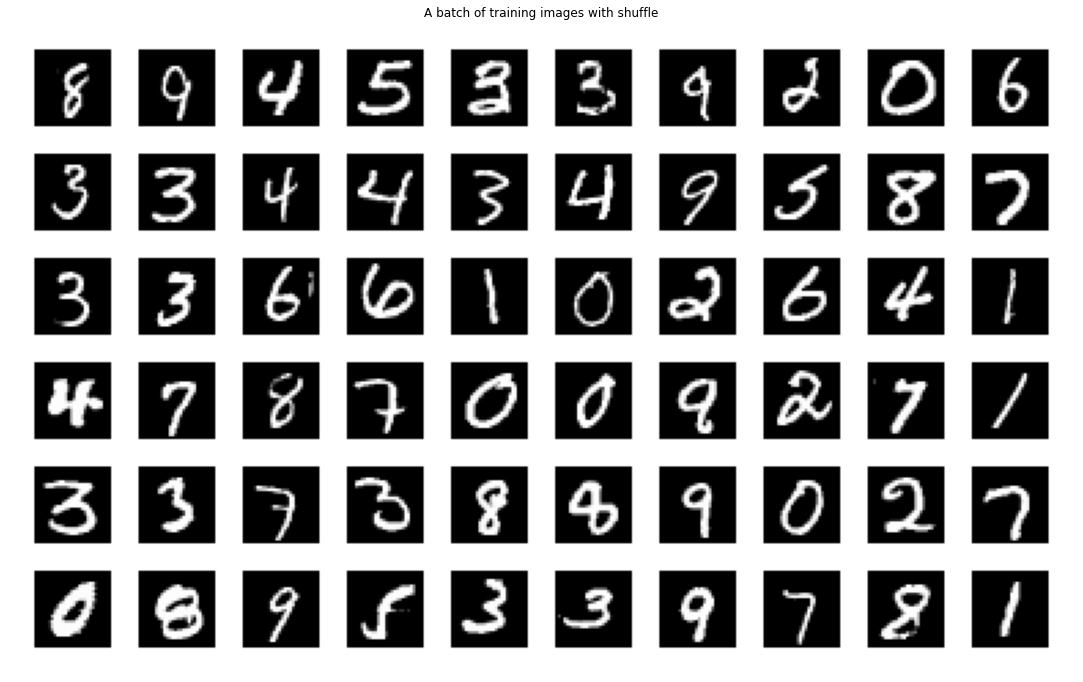

In [8]:
real_batch = next(iter(train_loader))

plt.figure(figsize = (22, 12))
plt.axis('off')
plt.title('A batch of training images with shuffle')

plt.imshow(np.transpose(torchvision.utils.make_grid(
                        real_batch[0].to(device),
                        padding=10,
                        normalize = True,
                        pad_value=1,
                        nrow=int(len(real_batch[0])/6)).cpu(), (1,2,0)))
plt.show()

### Generator class architecture

In [9]:
# G(z)

class generator(nn.Module):
    # initializers
    def __init__(self, input_noise, output_size):
        super(generator, self).__init__()
        self.fcn = torch.nn.Sequential(
        # Fully connected layer 1
        torch.nn.Linear(in_features=input_noise, out_features=256),
        torch.nn.LeakyReLU(negative_slope=0.2),
        # Fully connected layer 2
        torch.nn.Linear(in_features=256, out_features=512),
        torch.nn.LeakyReLU(negative_slope=0.2),
        # Fully connected layer 3
        torch.nn.Linear(in_features=512, out_features=1024),
        torch.nn.LeakyReLU(negative_slope=0.2),
        # Fully connected layer 4
        torch.nn.Linear(in_features=1024, out_features=output_size),
        torch.nn.Tanh()        
        )
    # forward method
    def forward(self, input_noise):
        ret = self.fcn(input_noise)
        return ret

#### Visualize generator class architecture

https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network

https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch

https://www.machinecurve.com/index.php/2020/02/27/visualizing-your-neural-network-with-netron/

### Discriminator class architecture

In [10]:
class discriminator(nn.Module):
    #initializers
    def __init__(self, input_size, n_classes ):  # not sure about the value of input size
        super(discriminator, self).__init__()
        self.fcn = torch.nn.Sequential(
        # Fully connected layer 1
        torch.nn.Linear(in_features=input_size, out_features=1024),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Dropout(p = 0.3),
            
        # Fully connected layer 2
        torch.nn.Linear(in_features=1024, out_features=512),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Dropout(p = 0.3),
        
        # Fully connected layer 3
        torch.nn.Linear(in_features=512, out_features=256),
        torch.nn.LeakyReLU(negative_slope=0.2),
        torch.nn.Dropout(p = 0.3),
            
        # Fully connected layer 4
        torch.nn.Linear(in_features=256, out_features=n_classes),
        torch.nn.Sigmoid(),
        )
    
    # forward method
    def forward(self, input_size):
        ret = self.fcn(input_size)
        return ret

#### Visualize discriminator class architecture

### Noise

fixed vs. random

In [11]:
# fixed_noise = torch.randn((5*5, 100)).to(device)
# random_noise = torch.randn((5*5, 100)).to(device)

In [12]:
# fixed_noise.shape

### Network

lr, loss, optimize, instance of generator and discriminator networks

In [13]:
lr = 0.0002

G = generator(input_noise=100, output_size=28*28)
D = discriminator(input_size=28*28, n_classes=1)
G.cuda()
D.cuda()

# binary cross entropy loss
BCE_loss = nn.BCELoss()

# Adam Optimizer
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)


# tb_writer.add_graph(G, torch.randn((5*5, 100)).to(device))
# tb_writer.add_graph(D, torch.randn((2, 32)).to(device))

### Show results function

In [14]:
def show_result(num_epoch, grid, path, show = False, save = True):
      
    plt.figure(figsize=(16, 12))
    
    plt.axis('off')
    plt.title('Generated Images')
    label = 'Epoch {0}'.format(num_epoch)
    plt.text(0.5, 0.04, label, ha='center')
    plt.imshow(np.transpose(grid, (1,2,0)))
    
    
    plt.savefig(path)
    
    
    if show:
        plt.show()
    else:
        plt.close()

### Show training/loss history function

In [15]:
def show_train_history(hist, show = False, save = True, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))
    
    y1 = hist['D_losses']
    y2 = hist['G_losses']
    
    plt.plot(x, y1, label = 'D_loss')
    plt.plot(x, y2, label = 'G_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc = 4)
    plt.grid(True)
    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        
    if show:
        plt.show()
    else:
        plt.close()

### Training parameters
Batch size, num_epochs

In [16]:
batch_size = 128
train_epoch = 10

### Results save folder

In [17]:
if not os.path.isdir('MNIST_GAN_results'):
    os.mkdir('MNIST_GAN_results')
if not os.path.isdir('MNIST_GAN_results/Random_results'):
    os.mkdir('MNIST_GAN_results/Random_results')
if not os.path.isdir('MNIST_GAN_results/Fixed_results'):
    os.mkdir('MNIST_GAN_results/Fixed_results')

### Start training

store results in tensor board

In [18]:
# noise = fixed_noise

D_losses = []
G_losses = []

for epoch in range(train_epoch):

    
    for images, labels in train_loader:
        
        # train discriminator D (temporarily one epoch only)
        D.zero_grad()
        
        # images shape from train_loader is torch.Size([60, 1, 28, 28])
        # flatten images shape will be torch.Size([60, 784])
        flatten_real_images = images.view(-1, 28*28).to(device)
        mini_batch = flatten_real_images.size()[0]  # value of mini_batch is 60
    
        real_labels = torch.ones(mini_batch, 1).to(device) # because sigmoid produces 2d output.
        fake_labels = torch.zeros(mini_batch, 1).to(device) # because sigmoid produces 2d output.
        
        # applying discriminator to real images
        real_outputs = D(flatten_real_images)
        
        D_real_loss = BCE_loss(real_outputs, real_labels)
        
        # applying discriminator to fake images
        fake_noise = torch.randn(mini_batch, 100).to(device) # 100 is noise dimension
        fake_outputs = D(G(fake_noise))
        D_fake_loss = BCE_loss(fake_outputs, fake_labels)
        
        # calculating total loss (real + fake)
        D_train_loss = D_real_loss + D_fake_loss
        
        # back propagation and optimization
        D_train_loss.backward()
        D_optimizer.step()
        
        # appending loss
        D_losses.append(D_train_loss.data)
        
        # train Generator (one epoch only)
        
        G.zero_grad()
        
        # applying discriminator to fake images (G(fake_noise))
        fake_des_outputs = D(G(fake_noise))
        
        G_train_loss = BCE_loss(fake_des_outputs, real_labels)
        G_train_loss.backward()
        G_optimizer.step()
        
        G_losses.append(G_train_loss.data)
        
    # applying tensor board logging
    if epoch % 2== 0:
        # G & D Loss
        print("Epoch:{}, G Loss:{}, D Loss:{}".format(epoch, G_train_loss, D_train_loss))
        #in case multiple cycles of training for discrminator see commented code below
        #print("E:{}, G Loss:{}, D Loss:{}".format(epoch, g_loss/num_steps, d_loss/num_steps/4))
        
        # Tensorboards Logging
        tb_writer.add_scalar('MNIST_GAN/D Loss', D_train_loss, epoch)
        
        tb_writer.add_scalar('MNIST_GAN/G Loss', G_train_loss, epoch)
        
        # need to put fixed vs random noise (if else statement)
        
        # if len(noise) == len(fixed_noise):
            
        generated_images = G(fake_noise).detach().cpu().view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(generated_images, nrow = 5, padding=10, pad_value=1, normalize=True)
        tb_writer.add_image('MNIST_GAN/Output', grid, epoch)

        fixed_p = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(epoch) + '.png'
        show_result(epoch, grid, path=fixed_p, save=True)

#         else:
#             generated_images = G(randomd_noise).detach().cpu().view(-1, 1, 28, 28)
#             grid = torchvision.utils.make_grid(generated_images, nrow = 5, padding=10, pad_value=1, normalize=True)
#             tb_writer.add_image('MNIST_GAN/Output', grid, epoch)

#             p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
#             show_result(grid, path=p, save=True)



# discriminator training of real images
tb_writer.add_graph(D, flatten_real_images) # flatten_real_images dimension is 60 x 784

# discriminator training of fake_noise
#tb_writer.add_graph(D, G(fake_noise)) G(fake_noise dimension is 60 x 784)

# geneartor training graph
#tb_writer.add_graph(G, torch.randn(mini_batch, 100).to(device)) # 100 is noise dimension hence input is 60 x 100


print("Training finished!... Saving training results")

# Save state dict of generator and discriminator

torch.save(G.state_dict(), "MNIST_GAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_GAN_results/disciminator_param.pkl")
        


Epoch:0, G Loss:0.7567560076713562, D Loss:1.3881866931915283
Epoch:2, G Loss:2.009892225265503, D Loss:0.4190663695335388
Epoch:4, G Loss:1.8764084577560425, D Loss:0.501690685749054
Epoch:6, G Loss:2.116103410720825, D Loss:0.5973424911499023
Epoch:8, G Loss:1.6751223802566528, D Loss:0.6999533176422119
Training finished!... Saving training results


### Visualize results

Save image as animation

In [19]:
images = []

for e in range(train_epoch):
    if e%2 == 0:
        img_name = 'MNIST_GAN_results/Fixed_results/MNIST_GAN_' + str(e) + '.png'
        print(img_name)
        images.append(imageio.imread(img_name))

    imageio.mimsave('MNIST_GAN_results/generation_animation.gif', images, fps = 0.5)

MNIST_GAN_results/Fixed_results/MNIST_GAN_0.png
MNIST_GAN_results/Fixed_results/MNIST_GAN_2.png
MNIST_GAN_results/Fixed_results/MNIST_GAN_4.png
MNIST_GAN_results/Fixed_results/MNIST_GAN_6.png
MNIST_GAN_results/Fixed_results/MNIST_GAN_8.png
